# Parking Ticket Predictions

This project is based on a data challenge from Michigan Data Science Team (MDST). 

The Michigan Data Science Team (MDST) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences (MSSISS) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - building deterioration. Blight violations are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

Our data comes from the Detroit Open Data Portal (https://data.detroitmi.gov/) and comes with two files: past_blight_tickets.csv and current_blight_tickets.csv. 

The first step in increasing blight ticket payment compliance is to better understand common indicators of when and why citizens do not pay their ticket fees. To do this, we will build a few supervised learning models to take a deeper look at the commonalities that people who do or don't pay their blight fees.   

The **files** include:

    past_blight_tickets.csv - training set of tickets issued 2004-2011
    current_blight_tickets.csv = the test set of all blight tickets issued 2012-2016
    addresses.csv and latalons.csv - used to map ticket_id to addresses
 
**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


# Exploring and Cleaning the Data

In [3]:
past_tickets = pd.read_csv('data/past_blight_tickets.csv', low_memory=False)

current_tickets = pd.read_csv('data/current_blight_tickets.csv', low_memory=False)

print('The input file has the shape ', past_tickets.shape)
print('\nOur fields are ', past_tickets.columns.values)

The input file has the shape  (250306, 35)

Our fields are  ['Unnamed: 0' 'ticket_id' 'agency_name' 'inspector_name' 'violator_name'
 'violation_street_number' 'violation_street_name' 'violation_zip_code'
 'mailing_address_str_number' 'mailing_address_str_name' 'city' 'state'
 'zip_code' 'non_us_str_code' 'country' 'ticket_issued_date'
 'hearing_date' 'violation_code' 'violation_description' 'disposition'
 'fine_amount' 'admin_fee' 'state_fee' 'late_fee' 'discount_amount'
 'clean_up_cost' 'judgment_amount' 'payment_amount' 'balance_due'
 'payment_date' 'payment_status' 'collection_status' 'grafitti_status'
 'compliance_detail' 'compliance']


In [4]:
# The target value for our prediction 

past_tickets.groupby('compliance').count()['ticket_id']

compliance
0.0    148283
1.0     11597
Name: ticket_id, dtype: int64

In [5]:
# There are about 100,000 nas in our target value. There are not  

target_nas = past_tickets[past_tickets['compliance'].isna()]
target_nas.groupby('disposition').count()['ticket_id'].sort_values(ascending=False)

disposition
Not responsible by Dismissal         48695
Not responsible by City Dismissal    34401
Not responsible by Determination      6639
PENDING JUDGMENT                       387
SET-ASIDE (PENDING JUDGMENT)           304
Name: ticket_id, dtype: int64

**Note on NA values in Target Field**

We see that the NA values in the 'compliance' field (our target field) represent issued tickets that have been revoked by the city. We can remove these from the dataset because we are interested only in parties where tickets have stayed issued by the city. 

In [6]:
# Remove dismissed or determinated tickets

past_tickets = past_tickets[~past_tickets['compliance'].isna()]

In [7]:
# Common Violations

num_violations = 7

print('The Most Common {} Violations \n'.format(num_violations))
print(past_tickets.groupby('violation_description').count()['ticket_id'].sort_values(ascending=False)[:num_violations])

The Most Common 7 Violations 

violation_description
Failure of owner to obtain certificate of compliance                                                    64414
Failure to obtain certificate of registration for rental property                                       23145
Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste    19072
Excessive weeds or plant growth one- or two-family dwelling or commercial Building                      16927
Allowing bulk solid waste to lie or accumulate on or about the premises                                  4879
Violation of time limit for approved containers to remain at curbside - early or late                    4200
Rodent harborage one-or two-family dwelling or commercial building                                       3619
Name: ticket_id, dtype: int64


Text(0.5, 0, 'Fine Amount ($USD)')

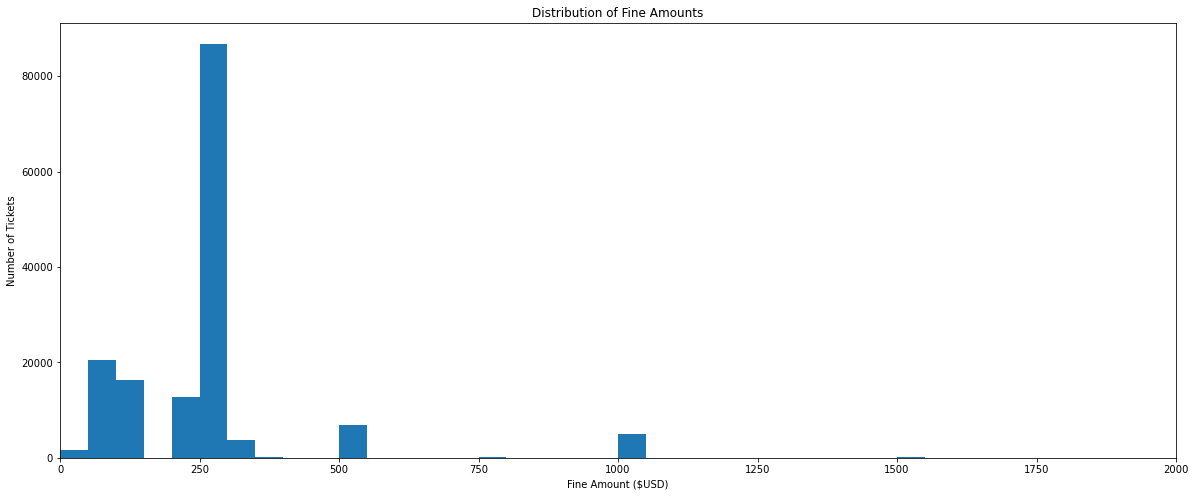

In [8]:
# Plot ticket
plt.figure(figsize=(20,8))
plt.xlim(0,2000)


plt.hist(past_tickets['fine_amount'], bins=200)

plt.title('Distribution of Fine Amounts')
plt.ylabel('Number of Tickets')
plt.xlabel('Fine Amount ($USD)')

# Cleaning the Data for Model Usage

In [71]:
# Target Variable
y = past_tickets['compliance']

# All columns in present_tickets.csv file
X = past_tickets[['ticket_id', 'agency_name', 'inspector_name', 'violator_name', 'violation_street_number',
                     'violation_street_name', 'violation_zip_code',
                     'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code', 
                     'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date', 'violation_code',
                     'violation_description', 'disposition', 'fine_amount', 'admin_fee', 'state_fee',
                     'late_fee', 'discount_amount', 'clean_up_cost', 'judgment_amount', 'grafitti_status']]

In [72]:
def check_for_nas(data):
    copy = data.copy()
    
    for col in copy.columns:
        
        if copy[col].isnull().values.any():
            num_nas = len(copy[copy[col].isnull()])
            proportion_na = num_nas/len(copy[col])
            
            print('There are nulls in column:', col)
            print('The number of NAs is {}'.format(num_nas))
            print('The proportion of nas in {} is {}'.format(col, proportion_na), '\n')

In [73]:
check_for_nas(X)

There are nulls in column: violator_name
The number of NAs is 26
The proportion of nas in violator_name is 0.00016262196647485615 

There are nulls in column: violation_zip_code
The number of NAs is 159880
The proportion of nas in violation_zip_code is 1.0 

There are nulls in column: mailing_address_str_number
The number of NAs is 2558
The proportion of nas in mailing_address_str_number is 0.015999499624718538 

There are nulls in column: mailing_address_str_name
The number of NAs is 3
The proportion of nas in mailing_address_str_name is 1.8764073054791094e-05 

There are nulls in column: state
The number of NAs is 84
The proportion of nas in state is 0.0005253940455341507 

There are nulls in column: zip_code
The number of NAs is 1
The proportion of nas in zip_code is 6.254691018263698e-06 

There are nulls in column: non_us_str_code
The number of NAs is 159877
The proportion of nas in non_us_str_code is 0.9999812359269452 

There are nulls in column: hearing_date
The number of NAs i

**Note on NA values**

We don't want to drop entire columns just because of a few NA values.

We first check to see if our na values have a proportion of nas higher than na_floor. Then, based on the type of data in the field, we either fill it with the median value, or an empty string "". 

In [74]:
# Pull out columns with high proportion of NA values, turn text into float data, and typecast other fields as floats 

def numericize_or_drop_col(data, na_floor=0.01):
    
    dropped_cols = []
    copy = data.copy()
    
    for col in copy.columns:
        
        #print(col)
        
        if copy[col].isnull().values.any(): #Drops columns with NA values
            
            proportion_na = len(copy[copy[col].isnull()])/len(copy[col])
            
            print('There are nulls in column:', col)
            print('The proportion of nas in {} is {}'.format(col, proportion_na), '\n')
            copy = copy.drop([col], axis=1)
        
        
        if type(copy[col][1]) == str: #Turn string data into numerical for model
            #Sorts unique values of series by frequency and returns integers instead of strings 
            #Note: this is particularly useful for decision trees models that make binary splits
            
            dropped_cols.append((col, 'text to integers'))
            
            unique_series = copy[col].groupby(copy[col]).count()
            unique_series = unique_series.sort_values(ascending=False)
            text_to_int_dict = {unique_value:float(i) for i, unique_value in enumerate(unique_series.index)}
            copy['%s_as_integer'.format(col)] = [text_to_int_dict[val] for val in copy.loc[:,col]].copy()

            copy = copy.drop([col], axis=1)
                  
                
        else: #typecast columns to floats
            #print('No nulls, moving on')
            copy[col] = copy[col].astype(np.float64)
                  
    return copy, dropped_cols

In [75]:
new_X, dropped_cols = numericize_or_drop_col(X)

There are nulls in column: violator_name
The proportion of nas in violator_name is 0.00016262196647485615 



KeyError: 'violator_name'

In [ ]:
def column_union(df1,df2):
    

# Modelling

In [40]:
# Model training, GridCV, MeanMaxNormalizer (Ridge Regression, Logistic, basic NNs), Random Forests

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [41]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print('Roc AUC score on data: {:.2f}'.format(roc_auc_score(y, clf.predict_proba(X)[:, 1])))

C:\Users\bensm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of RF classifier on training set: 0.93
Accuracy of RF classifier on test set: 0.93
Roc AUC score on data: 0.60


In [43]:
# Our Predictions probabilities with RandomForestClassifier

def blight_model():
    #print(X.head())

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


    clf = RandomForestClassifier(random_state=0, n_estimators=50, max_depth=3).fit(X, y)
    #print('Accuracy of RF classifier on training set: {:.2f}'
    #     .format(clf.score(X_train, y_train)))
    #print('Accuracy of RF classifier on test set: {:.2f}'
    #     .format(clf.score(X_test, y_test)))
    #print('Roc AUC score on data: {:.2f}'.format(roc_auc_score(y, clf.predict_proba(X)[:, 1])))

    preds = clf.predict_proba(current_tickets)
    rec = pd.Series([pred[1] for pred in preds], index = current_tickets['ticket_id'].astype(int))
    rec
    
    return rec

blight_model()

ticket_id
284932    0.089749
285362    0.070194
285361    0.083996
285338    0.083996
285346    0.084400
            ...   
376496    0.037589
376497    0.037589
376499    0.059594
376500    0.059594
369851    0.264841
Length: 61001, dtype: float64

# Model Evaluation

# Exporting Predictions